# Run biased MD with OPES

To be used to calculate a reference free enegy.

More information about OPES can be found [here](https://www.plumed.org/doc-master/user-doc/html/_o_p_e_s__m_e_t_a_d.html)

In [1]:
import numpy as np
import mdtraj as md

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import openmm
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [3]:
#handy function for the model system
import bgmol

def get_model(system_name, temperature=None):
    
    model = bgmol.system_by_name(system_name.replace('ModifiedPSI',''))
    
    if 'ModifiedPSI' in system_name:
        extraBias_str = '100*sin(0.5*theta)^2'
        extraBias = openmm.CustomTorsionForce(extraBias_str)
        psi_angles = md.compute_psi(md.Trajectory(model.positions, model.mdtraj_topology))[0]
        for i in range(len(psi_angles)):
            extraBias.addTorsion(*psi_angles[i])
            print(f"{system_name}, adding bias on psi{psi_angles[i]}: {extraBias_str}")
        model.system.addForce(extraBias)        
    
    if temperature is not None:
        model.reinitialize_energy_model(temperature=temperature)
    
    return model

In [4]:
#setup the system
temp = 300

system_name = 'AlanineTetrapeptideImplicit'

model = get_model(system_name)
model.positions.shape

Using downloaded and verified file: /tmp/AAA.pdb


(42, 3)

In [5]:
#some plotting functions
from matplotlib.colors import LogNorm

def get_phi_psi(trajectory, i=-1, model=model):
    if not isinstance(trajectory, md.Trajectory):
        # if isinstance(trajectory, torch.Tensor):
        #     trajectory = assert_numpy(trajectory.view(len(trajectory), *model.positions.shape))
        trajectory = md.Trajectory(trajectory, model.mdtraj_topology)
    phi = md.compute_phi(trajectory)[1][:,i]
    psi = md.compute_psi(trajectory)[1][:,i]
    return phi, psi

def plot_rama_traj(trajectory, w=None, get_phi=False, i=-1, model=model):
    phi, psi = get_phi_psi(trajectory, i)
    plot_range = [-np.pi, np.pi]
    
    #histogram
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.title("Histogram")
    plt.hist2d(phi, psi, 60, weights=w, norm=LogNorm(), range=[plot_range,plot_range])
    plt.xlim(plot_range)
    plt.ylim(plot_range)
    plt.xlabel("$\phi$")
    plt.ylabel("$\psi$")
    plt.gca().set_box_aspect(1)
    
    #trajectory
    plt.subplot(1,2,2)
    plt.title("Trajectory")
    end = len(phi)
    plt.scatter(range(end), phi, c=psi, s=10)
    plt.xlim([0, end])
    plt.xlabel("n_iter")
    plt.ylabel("$\phi$")
    plt.gca().set_box_aspect(0.5)
    plt.show()
    
    if get_phi:
        return phi

def plot_phi_FES(phi, w=None, n_bins='auto', T_high=temp, T_low=temp, ymax=20):
    plot_range = (-np.pi, np.pi)
    hist, edges = np.histogram(phi, bins=n_bins, range=plot_range)
    fes_estimate = -np.log(np.where(hist!=0,hist/hist.max(),np.nan))
    plt.plot(edges[:-1]+(edges[1]-edges[0])/2, fes_estimate, label="direct FES")
    DeltaF_T_high = None
    DeltaF_T_low = None
    try:
        ref_file = f'../FESreference/FES-{prior_name}-T{T_high}.dat'
        phi_ref, fes_ref = np.loadtxt(ref_file, usecols=(0,1), unpack=True)
        fes_ref /= (kB*T_high)
        plt.plot(phi_ref, fes_ref, label=f"reference {T_high}K", linestyle='dotted')
        ymax = max(ymax, np.amax(fes_ref))
        DeltaF_T_high = np.logaddexp.reduce(-fes_ref[phi_ref<0])-np.logaddexp.reduce(-fes_ref[phi_ref>0])
    except IOError:
        print('+++ Ref. file not found: '+ref_file+' +++')
    if w is not None:
        if n_bins == 'auto':
            n_bins = 50
        hist, edges =np.histogram(phi, bins=n_bins, range=plot_range, weights=w)
        fes_estimate = -np.log(np.where(hist!=0,hist/hist.max(),np.nan))
        plt.plot(edges[:-1]+(edges[1]-edges[0])/2, fes_estimate, label="reweighted FES")
        try:
            ref_file = f'../FESreference/FES-{target_name}-T{T_low}.dat'
            phi_ref, fes_ref = np.loadtxt(ref_file, usecols=(0,1), unpack=True)
            fes_ref /= (kB*T_low)
            plt.plot(phi_ref, fes_ref, label=f"reference {T_low}K", linestyle='dotted')
            ymax = max(ymax, np.amax(fes_ref))
            DeltaF_T_low = np.logaddexp.reduce(-fes_ref[phi_ref<0])-np.logaddexp.reduce(-fes_ref[phi_ref>0])
        except IOError:
            print('+++ Ref. file not found: '+ref_file+' +++')
    plt.xlim(plot_range)
    plt.ylim(bottom=0, top=min(ymax, max(fes_estimate)))
    plt.xlabel("$\phi$")
    plt.ylabel("FES")
    plt.legend()
    plt.show()
    #references are from OPES
    if DeltaF_T_high is not None:
        print(f'DeltaF at {T_high:4g}K: {DeltaF_T_high:.3f}')
    if DeltaF_T_low is not None:
        print(f'DeltaF at {T_low:4g}K: {DeltaF_T_low:.3f}')
    DeltaF = -np.log(np.count_nonzero(phi>0) / np.count_nonzero(phi<0))
    print('  DeltaF direct: %.3f' % DeltaF)
    if w is not None:
        DeltaF = -np.log(np.sum(w[phi>0]) / np.sum(w[phi<0]))
        print('DeltaF reweight: %.3f' % DeltaF)

In [6]:
%%time
#equilibrate

pace = 500
n_equil = 500

integrator = openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 1./unit.picosecond, 2.*unit.femtosecond)
simulation = openmm.app.Simulation(model.topology, model.system, integrator)
simulation.context.setPositions(model.positions)

simulation.minimizeEnergy()
simulation.step(pace*n_equil)

equil_positions = simulation.context.getState(getPositions=True).getPositions()

CPU times: user 10.1 s, sys: 2.44 s, total: 12.5 s
Wall time: 12.7 s


In [7]:
#add plumed force
from openmmplumed import PlumedForce

system_name = 'AlanineTetrapeptideImplicit'
temp = 300
pace = 500

plumed_dat = '# vim:ft=plumed\n'
if 'AlanineDipeptide' in system_name:
    plumed_dat +=  f"""
phi: TORSION ATOMS=5,7,9,15
psi: TORSION ATOMS=7,9,15,17

opes: OPES_METAD TEMP={temp} ARG=phi,psi PACE={pace} BARRIER=40 NLIST

PRINT FILE=COLVAR STRIDE={pace} FMT=%g ARG=*
    """
elif 'AlanineTetrapeptide' in system_name:
    plumed_dat +=  f"""
phi1: TORSION ATOMS=5,7,9,15
phi2: TORSION ATOMS=15,17,19,25
phi3: TORSION ATOMS=25,27,29,35
psi1: TORSION ATOMS=7,9,15,17
psi2: TORSION ATOMS=17,19,25,27
psi3: TORSION ATOMS=27,29,35,37

opes: OPES_METAD TEMP={temp} ARG=phi1,phi2,phi3 PACE={pace} BARRIER=40 NLIST

PRINT FILE=COLVAR STRIDE={pace} FMT=%g ARG=*
    """
else:
    assert False, 'unknown systsem: ' + system_name

model = get_model(system_name)
model.system.addForce(PlumedForce(plumed_dat))

plumed_dat += f'\nENDPLUMED\nfile generated automatically when running the notebook'
with open('plumed.dat', 'w') as f:
    f.write(plumed_dat)

model.system.getForces()

Using downloaded and verified file: /tmp/AAA.pdb


[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7f1fcb706f90> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7f1fcbc2fea0> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x7f1fc41787b0> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f1fc4178840> >,
 <openmm.openmm.GBSAOBCForce; proxy of <Swig Object of type 'OpenMM::GBSAOBCForce *' at 0x7f1fc41788d0> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7f1fc4178960> >,
 <openmm.openmm.Force; proxy of <Swig Object of type 'OpenMM::Force *' at 0x7f1fc41789f0> >]

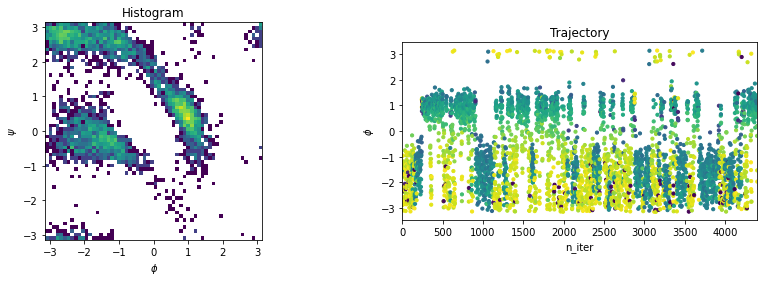

In [ ]:
%%time
#run the biased MD

pace = 500
n_iter = 40_000

integrator = openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 1./unit.picosecond, 2.*unit.femtosecond)
simulation = openmm.app.Simulation(model.topology, model.system, integrator)
simulation.context.setPositions(equil_positions)
MDdata = np.empty((n_iter, *model.positions.shape))

    
#run MD
for n in range(n_iter):
    simulation.step(pace)
    MDdata[n] = simulation.context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
    if (n+1) % (n_iter//100) == 0:
        clear_output(wait=True)
        if 'Chignolin' in system_name:
            plot_tics_traj(MDdata[:n+1])
        else:
            plot_rama_traj(MDdata[:n+1])
    print(f'sampling...  {n/n_iter:.2%}', end='\r')

In [ ]:
from plumed import read_as_pandas
colvar = read_as_pandas('COLVAR')
time = colvar['time']
logw = colvar['opes.bias']/(kB*temp)
if 'Tetra' in system_name:
    phi = colvar['phi3']
    psi = colvar['psi3']
else:
    phi = colvar['phi']
    psi = colvar['psi']

In [ ]:
plt.plot(time, logw, '.')
plt.xlabel('time')
plt.ylabel('bias')
plt.show()
plot_FES(phi, w=np.exp(logw), ymax=100, n_bins=100)

In [ ]:
from calcFES import calcFES

grid = np.linspace(-np.pi, np.pi, 75)
grid2D = np.meshgrid(grid, grid)

bw = 0.1
fes = calcFES(grid2D, (bw,bw), (phi,psi), logw, periodic=True)
plt.imshow(fes, vmax=16, origin='lower')
plt.colorbar(label='Free Energy [$k_\mathrm{B}T$]', extend='max')
plt.xlabel('$\phi$')
plt.ylabel('$\psi$')
plt.show()

In [ ]:
bw = 0.05
fes = calcFES(grid, bw, phi, logw, periodic=True)
plt.plot(grid, fes, label='reweighted')
# plot_FES(phi, ymax=100, n_bins=100)
plot_FES(phi, w=np.exp(logw), ymax=100, n_bins=100)